In [1]:
import warnings
import matplotlib 
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')  #过滤代码运行过程中烦人的警告
matplotlib.rcParams['axes.unicode_minus']=False #解决画图中
from jqdatasdk import *
auth('18571452047', 'XIAOsikang123456')

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
def option_code(df,price,ContractType):
    df=df.sort_values(by='exercise_price')
    df=df.reset_index()
    df.loc[:,'exercise_price']=abs(df.loc[:,'exercise_price']-price)
    idx=df.loc[:,'exercise_price'].idxmin()
    code=df.loc[idx-1:idx+1,'code'].values
    if ContractType=='p':
        code=code[::-1]
    return code
def get_option_code(date):
    price=get_price('510050.XSHG',count=1,end_date=date,fq='none',fields=['open'])['open'].values[0]
    q=query(opt.OPT_DAILY_PREOPEN).filter(opt.OPT_DAILY_PREOPEN.date, opt.OPT_DAILY_PREOPEN.underlying_name=='50ETF')
    df=opt.run_query(q)
    df=df.loc[:,['code','trading_code','exercise_price','exercise_date']]
    df=df[df['exercise_date']==df['exercise_date'].min()].reset_index()
    row,col=df.shape
    if row>0:
        for i in range(row):
            scode=df.loc[i,'trading_code']
            if scode[6]=='C' and scode[11]=='M':
                df.loc[i,'CP']='c'
            elif scode[6]=='P' and scode[11]=='M':
                df.loc[i,'CP']='p' 
        df1=df[df['CP']=='c']
        df2=df[df['CP']=='p']
        code1=option_code(df1,price,'c')
        code2=option_code(df2,price,'p')
        code1=[str(code)+'.XSHG' for code in code1]
        code2=[str(code)+'.XSHG' for code in code2]
        return code1,code2
    else:
        print(date,'这一天取不到期权合约！！')
        return 'None','None'  

In [3]:
###运行时间约1分钟，耐心等待！！

Code_itm=[] ###实值期权代码列表
Code_atm=[] ###平值期权代码列表
Code_otm=[] ###虚值期权代码列表
trade_days=get_trade_days('2017-1-1','2018-5-20')
for k,date in enumerate(trade_days[:]):
    code_c,code_p=get_option_code(date)
    Code_itm.append([code_c[0],code_p[0]])
    Code_atm.append([code_c[1],code_p[1]])
    Code_otm.append([code_c[2],code_p[2]])
print('运行完毕！')

运行完毕！


In [4]:
Code_itm[0]  ###2017-1-3的实值认购，实值认沽期权代码

['10000002.XSHG.XSHG', '10000008.XSHG.XSHG']

In [5]:
###计算每天的上下轨
def Price_Range(date,parameters):
    price = get_price('510050.XSHG',end_date=date,count=parameters[0]+1,fq='none',fields=['open','high','low','close'])
    HH=max(price['high'].values[:-1])
    HC=max(price['close'].values[:-1])
    LC=min(price['close'].values[:-1])
    LL=min(price['low'].values[:-1])
    Range = max(HH-LC,HC-LL)
    p     = price.iloc[-1,0]
    p_up  = round(p+parameters[1]*Range,3)
    p_down= round(p-parameters[2]*Range,3)
    return p_up,p_down 
###计算总收益TR、年华收益AR、波动率Vo、夏普比SR、最大回撤MD
def Indicators(value):
    value=list(value)
    TR=value[-1]-1
    AR=pow(value[-1],252/len(value))-1
    value=pd.Series(value)
    Returns=value.pct_change(1).dropna()
    Vo=sqrt(Returns.var()*252)
    SR=AR/Vo
    drawback=[]
    for i,v in enumerate(value):
        drawback.append(max(1-value[i:]/v))
    MD=max(drawback)
    return TR*100,AR*100,Vo*100,SR,MD*100

In [6]:
##策略函数。
'''
输入参数：
Type     : 字符串类型，表示期权合约类型。包括'itm'(实值期权)，'atm'(平值合约)，'otm'(虚值合约)。
flag     : 列表。包含两个元素，形成买入卖出方式。第1个元素：向上突破时买入（'Buy'）还是卖出('Sell');第2个元素:向下突破时买入('Buy')还是卖出('Sell')。(
cost     : 单边手续费，默认为0.0005（5元/张）。
DualPara : Dual Thrust参数列表。第1个元素为历史天数Num，第2个为向上突破系数Ks,第3个为向下突破系数Kx。
period   : 是否为样本内测试。可选参数：样本内:'inSample'，样本外：'outSample'，全样本：'allSample'。

输出参数：
trade_days:交易日列表，主要为画图时所用。
value     :每日净值列表。
'''
def option_strategy(Type='itm',flag=['Buy','Sell'],DualPara=[3,0.3,0.3],cost=0.0005,period='inSample'):
    
    LSflag=0               ###突破信号标志位，默认为0，向上突破置为1，向下突破置为-1。
    value=[10000]          ###资金净值列表，初始资金为10000元
    u_code='510050.XSHG'   ###标的50ETF代码
    
    if   period=='inSample':
        trade_days=get_trade_days('2017-01-01','2018-5-20')
    elif period=='outSample':
        trade_days=get_trade_days('2018-05-21','2019-5-20')
    elif period=='allSample':
        trade_days=get_trade_days('2017-01-01','2019-5-20')
        
    for k,date in enumerate(trade_days[:]):
        
        code_c,code_p=get_option_code(date)
        
        ###认购合约代码:c_code,认沽合约代码:p_code
        if Type=='itm':
            c_code,p_code=code_c[0],code_p[0] ###实值期权
        elif Type=='atm':
            c_code,p_code=code_c[1],code_p[1] ###平值期权
        elif Type=='otm':
            c_code,p_code=code_c[2],code_p[2]  ###虚值期权

        if len(c_code)<6 or len(p_code)<6:###不能取得正确期权合约代码时，跳过这一天
            value.append(value[-1])
            continue

        code=[u_code,c_code,p_code]  ###需要取得数据的证券代码

        p_up,p_down = Price_Range(date,DualPara) ###突破的上下轨

        ###取得当天50ETF、认购合约、认沽合约的1分钟数据，第一列为50ETF,第二列为认购合约，第三列为认沽合约
        sta_date=date
        end_date=date+dt.timedelta(days=1)
        price=get_price(code,sta_date,end_date,frequency='1m',fq='none',fields=['close'])['close']

        ###判断每分钟50ETF收盘价是否突破，向上突破LSflag置为1，向下突破LSflag置为-1，否则继续为0
        for i in range(len(price)):
            p =price.iloc[i,0]###50ETF每分钟收盘价
            if LSflag==0:

                ###向上突破
                if p>p_up:
                    LSflag=1
                    ###向上突破买入认购
                    if flag[0]=='Buy':
                        c1=price.iloc[i,1] ###突破时认购期权的价格
                        c2=price.iloc[-1,1]###收盘时认购期权的价格
#                         print(c_code,price.index[i])
                    ###向上突破卖出认沽
                    elif flag[0]=='Sell':
                        c1=price.iloc[i,2] ###突破时认沽期权的价格
                        c2=price.iloc[-1,2]###收盘时认沽期权的价格
#                         print(p_code,price.index[i])
                    break   ###一旦今天有突破信号，则不再继续判断。突破时做多收盘时平仓即可

                ###向下突破
                elif p<p_down:
                    LSflag=-1
                    if flag[1]=='Buy':
                        c1=price.iloc[i,2] ###突破时认沽期权的价格
                        c2=price.iloc[-1,2]###收盘时认沽期权的价格
#                         print(p_code,price.index[i])
                    elif flag[1]=='Sell':
                        c1=price.iloc[i,1]  ###突破时认购期权的价格
                        c2=price.iloc[-1,1] ###收盘时认购期权的价格
#                         print(c_code,price.index[i])
                    break    

        ###计算每日收益，净值存放在value列表里  

        if   LSflag== 1 :
            num=int(value[-1]*0.1/c1/10000) ###投入总金额10%，计算张数。
            if flag[0]=='Buy':
                profit=(c2-c1-2*cost)*10000   
            elif flag[0]=='Sell':
                profit=(c1-c2-2*cost)*10000
            value.append(value[-1]+num*profit) ###每日净值

        elif  LSflag==-1:
            num=int(value[-1]*0.1/c1/10000) 
            if flag[1]=='Buy':
                profit=(c2-c1-2*cost)*10000
            elif flag[1]=='Sell':
                profit=(c1-c2-2*cost)*10000
            value.append(value[-1]+num*profit) 
            
        else:
            num=0
            c1,c2=0,0
            value.append(value[-1])
 
        LSflag=0   
    #print(c1,c2,num,value[-1])
    value=[i/value[0] for i in value]
    return trade_days,value

In [ ]:
###运行需要大概1分钟，耐心等待！！
###样本内默认参数回测效果
trade_days,value=option_strategy(Type='itm',flag=['Buy','Sell'],DualPara=[3,0.3,0.3],cost=0.0005,period='inSample')

NameError: name 'value' is not defined

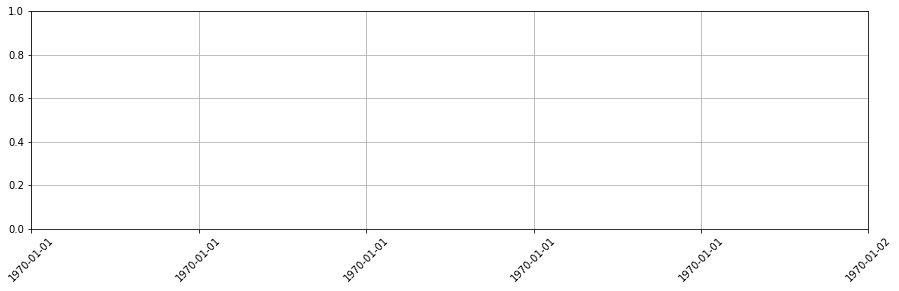

In [10]:
###画图
plt.figure(figsize=(15,4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))###横坐标设置为日期
plt.grid()
plt.xticks(rotation=45)
plt.plot(trade_days,value[1:])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Dual Thrust在期权上的应用')
plt.show()